# analyse de marée, cas synthétique

On fait l'hypothèse que le signal est la somme d'un bruit et de signaux aux fréquences harmoniques de marée:
$$
\begin{align}
y_i = b_0 + \sum_c \beta_c \cos \big ( \omega_c t_i - \phi_c \big) + e_i
\end{align}
$$
où $c$ désigne le constituent de marée (M2, S2, O1, K1, etc ...), $b_0$ est ...

Les inconnues recherchées sont $\beta_c$ et les $\phi_c$.
On résout le problème grâce une méthode des moindres carrés.
Il faut amener l'équation sous la bonne forme:

$$
\begin{align}
y_i &= b_0 + \sum_c \beta_c \cos \phi_c \cos \omega_c t_i 
+ \beta_c \sin \phi_c \sin \omega_c t_i 
+ e_i \\
&= b_0 + \sum_c a_c \cos \omega_c t_i 
+ b_c \sin \omega_c t_i 
+ e_i 
\end{align}
$$


$$
\begin{align}
y_i &= b_0 + \sum_c \beta_c \cos \phi_c \cos \omega_c t_i 
+ \beta_c \sin \phi_c \sin \omega_c t_i 
+ e_i \\
&= b_0 + \sum_c a_c \cos \omega_c t_i 
+ b_c \sin \omega_c t_i 
+ e_i 
\end{align}
$$

Il s'agit donc maintenant de résoudre le problème matriciel suivant:

$$
\begin{align}
\mathbf{Y} = \mathbf{X} \mathbf{B}
\end{align}
$$

où les matrices $\mathbf{Y},\mathbf{X},\mathbf{B}$ sont données par:
...


La solution minimisant la norme au carré des erreurs est donnée par:
$$
\begin{align}
\mathbf{B} = (\mathbf{X}'\mathbf{X})^{-1} \mathbf{X}' \mathbf{Y}
\end{align}
$$



Documentation:
    
- [xarray](http://xarray.pydata.org/en/stable/index.html)

- [normal distributions](https://en.wikipedia.org/wiki/Normal_distribution)

- recherche sur google

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

from datetime import datetime,timedelta

%matplotlib inline
import matplotlib.pyplot as plt

## génère des données synthétiques

In [3]:
t = pd.date_range('2000-01-01', freq='H', periods=365 * 24)
time = xr.DataArray((t-t[0])/pd.Timedelta('1D'), \
                    dims=['time']).rename('time')
constituents = xr.DataArray(['M2','S2'],dims=['constituents']) #.rename('constituents')
omega = xr.DataArray([1.9322,2.], dims=['constituents'], coords={'constituents': constituents})

# vrais amplitude, phase
beta = (xr.DataArray([1.,.5], dims=['constituents'], 
                    coords={'constituents': constituents})
        .rename('beta'))
phi = (xr.DataArray([0.,0.], dims=['constituents'], 
                  coords={'constituents': constituents}).rename('phi'))

y_tide = beta*np.cos(2.*np.pi*omega*time+phi)

In [4]:
y_tide

<xarray.DataArray (constituents: 2, time: 8760)>
array([[1.000000e+00, 8.747635e-01, 5.304224e-01, ..., 9.974020e-01,
        8.375853e-01, 4.679761e-01],
       [5.000000e-01, 4.330127e-01, 2.500000e-01, ..., 5.666491e-15,
        2.500000e-01, 4.330127e-01]])
Coordinates:
  * constituents  (constituents) <U2 'M2' 'S2'
  * time          (time) float64 0.0 0.04167 0.08333 0.125 ... 364.9 364.9 365.0

### illustration du signal de marée, cycle vive eau/ morte eau

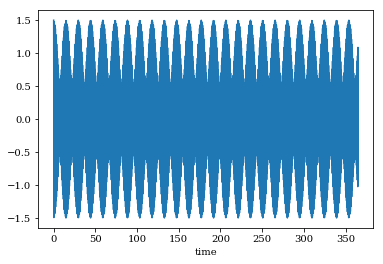

In [6]:
y_tide.sum('constituents').plot()

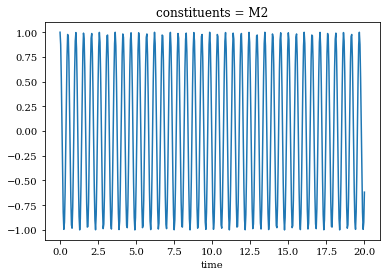

In [9]:
y_tide.sel(time=slice(0,20), constituents='M2').plot()

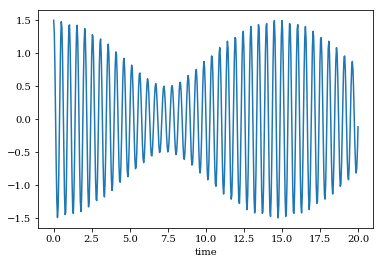

In [5]:
y_tide.sum('constituents').sel(time=slice(0,20)).plot()

## generation du bruit

In [16]:
noise_level = 10.
N_realisations = 100
noise = (xr.DataArray(noise_level*np.random.randn(time.size, N_realisations), 
                      coords={'time':time},
                      dims=['time','realisation'])
        )

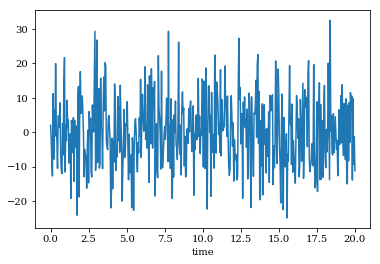

In [17]:
noise.isel(realisation=0).sel(time=slice(0,20)).plot()

In [9]:
help(np.random.randn)

Help on built-in function randn:

randn(...) method of numpy.random.mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `numpy.random.standard_normal`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    If positive int_like arguments are provided, `randn` generates an array
    of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1. A single float randomly sampled
    from the distribution is returned if no argument is provided.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, must be non-negative.
        If no argu

In [18]:
Y = y_tide.sum('constituents') + noise
Y

<xarray.DataArray (time: 8760, realisation: 100)>
array([[ 3.529014, 17.459319, 14.220619, ..., -6.719432, 12.901122, 17.192371],
       [-0.364972,  2.241933, -1.330093, ...,  0.650485, 13.719384,  3.338784],
       [-8.088616,  1.98804 , -0.600006, ..., -3.561581,  4.29527 , -3.060434],
       ...,
       [-3.767822, 18.97393 ,  2.384835, ...,  5.318366,  1.535555, 19.029696],
       [ 4.445311, -1.841856, -9.160745, ..., 11.842089, -6.516208, -4.906729],
       [ 8.030225, -0.768432, -3.463318, ..., -7.933765, 15.625786, 11.691545]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 364.9 364.9 365.0
Dimensions without coordinates: realisation

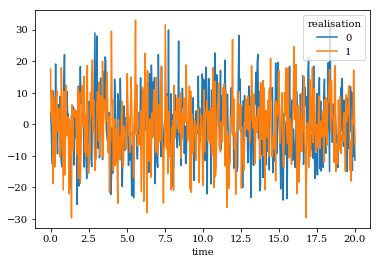

In [19]:
Y.isel(realisation=slice(0,2)).sel(time=slice(0,20)).plot.line(x='time')

In [20]:
X = np.hstack((np.ones((time.size,1)), 
               np.cos(2.*np.pi*omega*time).values.T, 
               np.sin(2.*np.pi*omega*time).values.T))

In [22]:
X

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  8.74763515e-01,  8.66025404e-01,
         4.84550094e-01,  5.00000000e-01],
       [ 1.00000000e+00,  5.30422413e-01,  5.00000000e-01,
         8.47733486e-01,  8.66025404e-01],
       ...,
       [ 1.00000000e+00,  9.97401953e-01,  1.13329815e-14,
         7.20371012e-02, -1.00000000e+00],
       [ 1.00000000e+00,  8.37585254e-01,  5.00000000e-01,
         5.46306638e-01, -8.66025404e-01],
       [ 1.00000000e+00,  4.67976087e-01,  8.66025404e-01,
         8.83741128e-01, -5.00000000e-01]])

In [23]:
X.shape

(8760, 5)

In [24]:
def get_solution(X, Y):
    B = np.linalg.lstsq(X,Y.values)[0]
    Nc = int((B.shape[0]-1)/2)
    ds = xr.Dataset({'b0': (['realisations'], B[0,:]),
                     'a': (['realisations','constituents'], B[1:Nc+1,:].T),
                     'b': (['realisations','constituents'], B[Nc+1:,:].T)}, 
                     coords={'constituents': constituents})
    return ds

ds = get_solution(X,Y)
ds

/home1/homedir5/perso/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<xarray.Dataset>
Dimensions:       (constituents: 2, realisations: 100)
Coordinates:
  * constituents  (constituents) <U2 'M2' 'S2'
Dimensions without coordinates: realisations
Data variables:
    b0            (realisations) float64 -0.04639 -0.1869 ... -0.04854 0.04608
    a             (realisations, constituents) float64 1.153 0.2777 ... 0.5688
    b             (realisations, constituents) float64 0.2038 ... -0.07604

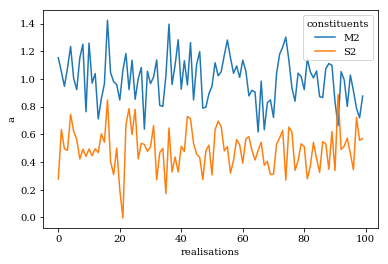

In [25]:
ds.a.plot.line(x='realisations')

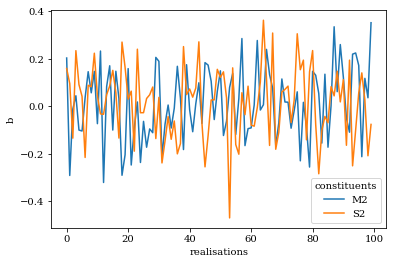

In [26]:
ds.b.plot.line(x='realisations')

---

## de manière plus compact

In [27]:
def solve_pb(amplitudes, noise_level, dt=1/24., T=360, N_realisations=100):
    
    # timle interval
    t_start = datetime(2000, 1, 1)
    t_end = t_start+timedelta(T)
    t = pd.date_range(start=t_start, end=t_end, freq=timedelta(dt))
    time = xr.DataArray((t-t[0])/pd.Timedelta('1D'), \
                        dims=['time']).rename('time')

    # vrais amplitude, phase
    beta = (xr.DataArray(amplitudes, dims=['constituents'], 
                        coords={'constituents': constituents})
            .rename('beta'))
    phi = (xr.DataArray([0.,0.], dims=['constituents'], 
                      coords={'constituents': constituents}).rename('phi'))

    y_tide = beta*np.cos(2.*np.pi*omega*time+phi)

    noise = (xr.DataArray(noise_level*np.random.randn(time.size, N_realisations), 
                          coords={'time':time},
                          dims=['time','realisation'])
            )

    Y = y_tide.sum('constituents') + noise

    X = np.hstack((np.ones((time.size,1)), 
               np.cos(2.*np.pi*omega*time).values.T, 
               np.sin(2.*np.pi*omega*time).values.T))
    
    ds = get_solution(X,Y)

    return ds

In [28]:
ds = solve_pb([1., .5], .1)
ds

/home1/homedir5/perso/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<xarray.Dataset>
Dimensions:       (constituents: 2, realisations: 100)
Coordinates:
  * constituents  (constituents) <U2 'M2' 'S2'
Dimensions without coordinates: realisations
Data variables:
    b0            (realisations) float64 -0.0003754 -0.0004962 ... 0.001189
    a             (realisations, constituents) float64 1.003 0.501 ... 0.4995
    b             (realisations, constituents) float64 0.0005919 ... 0.001386

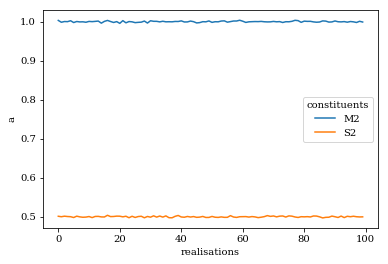

In [29]:
ds.a.plot.line(x='realisations')

# Que calcule-t-on avec les lignes suivantes?

In [31]:
ds.a.mean('realisations')

<xarray.DataArray 'a' (constituents: 2)>
array([0.999888, 0.499763])
Coordinates:
  * constituents  (constituents) <U2 'M2' 'S2'

In [30]:
ds.a.std('realisations')

<xarray.DataArray 'a' (constituents: 2)>
array([0.001571, 0.001459])
Coordinates:
  * constituents  (constituents) <U2 'M2' 'S2'

/home1/homedir5/perso/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


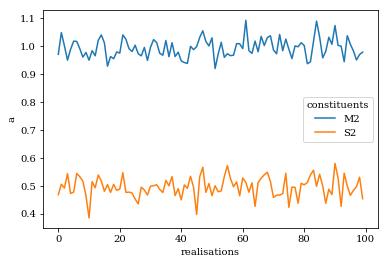

In [33]:
ds = solve_pb([1., .5], .1, dt=20.1)
ds.a.plot.line(x='realisations')